# 1. Looking at old_stft and new_stft

In [1]:
import numpy as np
from scipy import io
import h5py
import matplotlib.pyplot as plt

# old_stft = io.loadmat('old_stft.mat')# , {'new_stft_real': new_stft_real, 'new_stft_imag': new_stft_imag})old_stft = h5py.File("old_stft.mat", "r")
old_stft = h5py.File("old_stft.mat", "r")
stft_real_old = np.asarray(old_stft['old_stft_real'])
stft_imag_old = np.asarray(old_stft['old_stft_imag'])

# save new stft data
new_stft = io.loadmat('new_stft.mat')# , {'new_stft_real': new_stft_real, 'new_stft_imag': new_stft_imag})
stft_real_new = new_stft['stft_real_new']
stft_imag_new = new_stft['stft_imag_new']


In [2]:
stft_real_old.shape

(51, 65, 129, 16)

In [3]:
stft_imag_old.shape

(51, 65, 129, 16)

In [4]:
stft_real_new.shape

(51, 65, 129, 16)

In [5]:
stft_imag_new.shape

(51, 65, 129, 16)

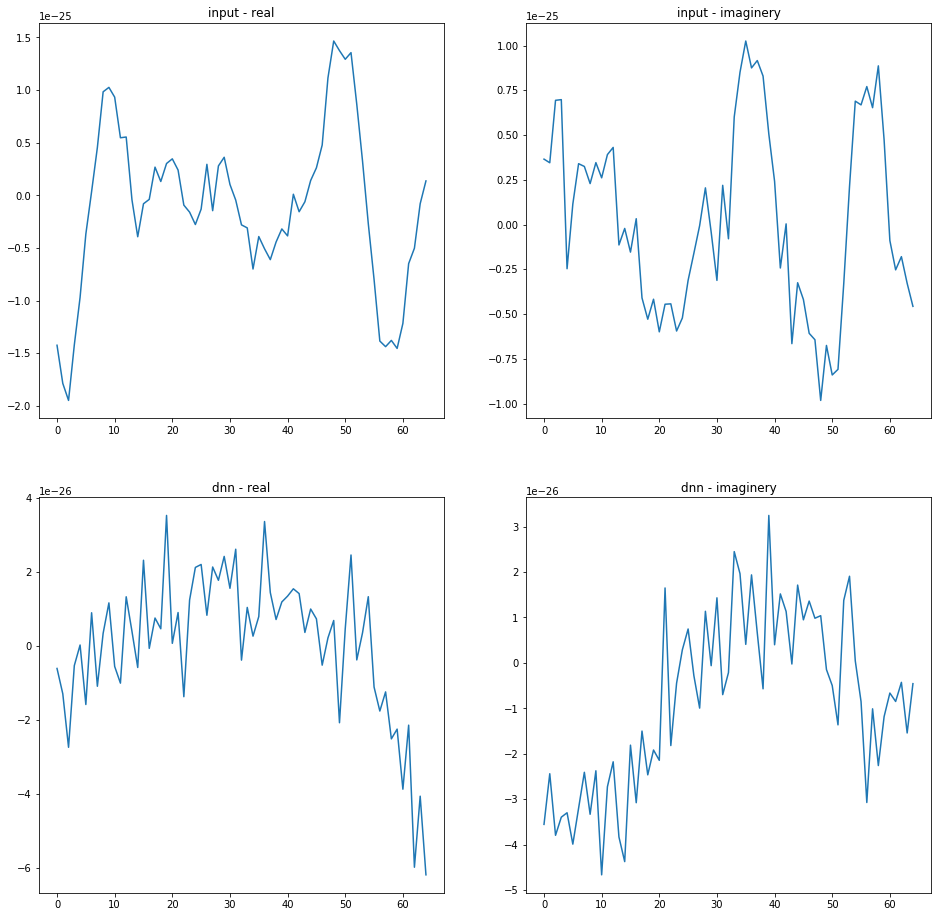

In [6]:
beam_num = 24
segment_num = 63
k = 4

fig, axes = plt.subplots(2, 2, figsize = (16,16))
axes[0, 0].plot(stft_real_old[beam_num, :, segment_num, k]) # is this correct?
axes[0, 0].set_title('input - real')
axes[0, 1].plot(stft_imag_old[beam_num, :, segment_num, k])
axes[0, 1].set_title('input - imaginery')

axes[1, 0].plot(stft_real_new[beam_num, :, segment_num, k]) # is this correct?
axes[1, 0].set_title('dnn - real')
axes[1, 1].plot(stft_imag_new[beam_num, :, segment_num, k])
axes[1, 1].set_title('dnn - imaginery')
plt.show()

# 2. Looking at training data (x, y, y_hat_dnn, and y_hat_cnn)

torch.Size([1, 130])


../lib/lenet.py:51: UserWarning: lenet: not using pooling
  warnings.warn('lenet: not using pooling')


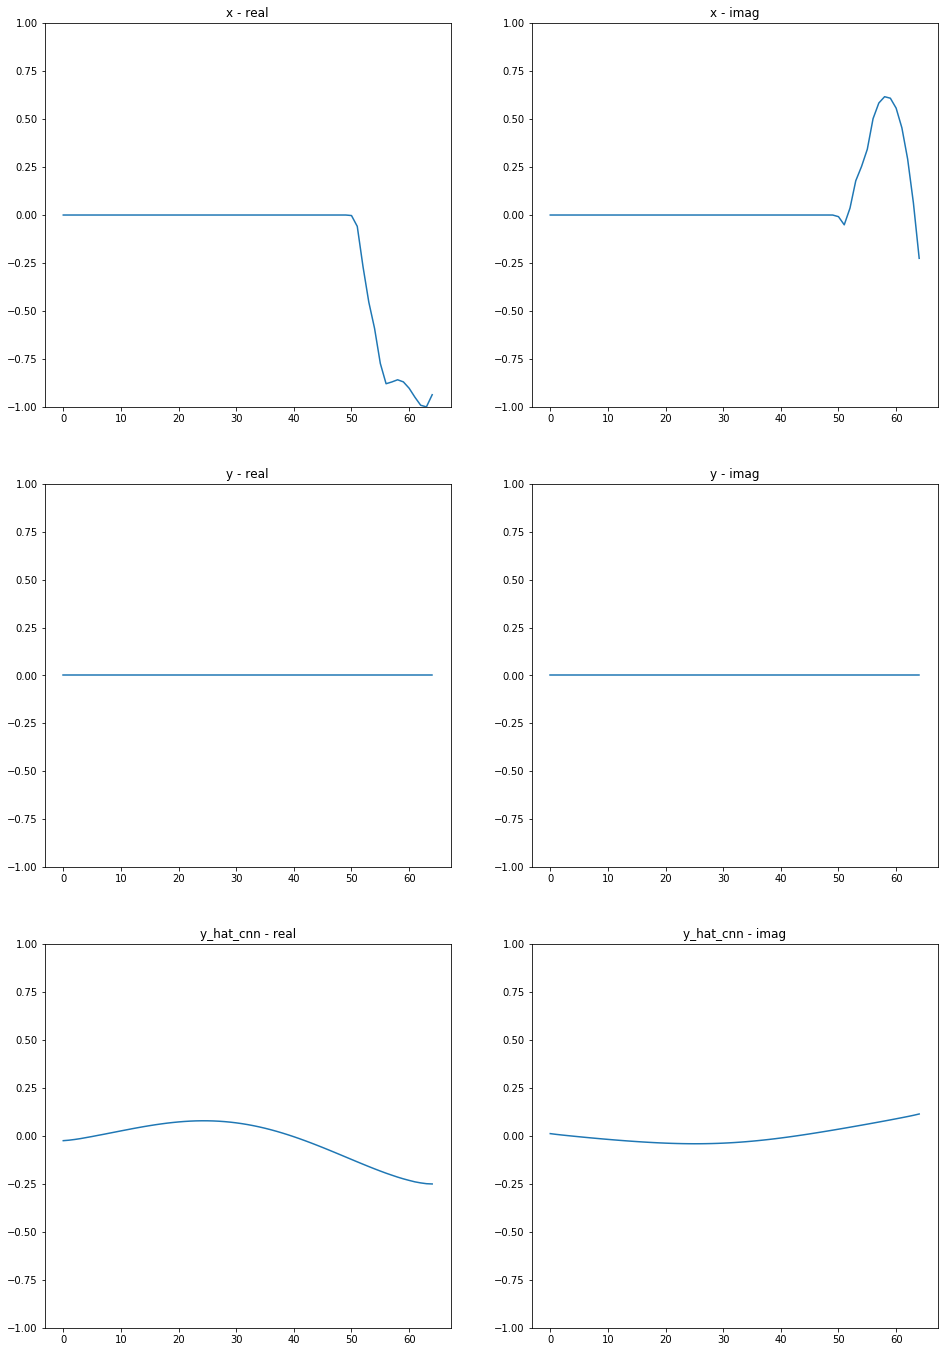

In [10]:
import h5py
import numpy as np
import os
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable

import sys
sys.path.insert(0, '..')
from lib.utils import load_model
from lib.lenet import LeNet

model = '20180705164352_7_evaluated'
k = 4
n_scat = 1 # [1, 2, 3]
sample_index = 0

home = os.path.expanduser('~')
fname = os.path.join(home,'Downloads', '20180402_L74_70mm', 'train_' + str(n_scat) + '.h5')

    
# check if files exist
if not os.path.isfile(fname):
    raise IOError(fname + ' does not exist.')

# Open file
with h5py.File(fname, 'r') as f:

    # Get number of samples available for each type
    real_available = f['/' + str(k) + '/X/real'].shape[0]
    imag_available = f['/' + str(k) + '/X/imag'].shape[0]
    samples_available = min(real_available, imag_available)


    # load the data
    inputs_real = f['/' + str(k) + '/X/real'][sample_index]
    inputs_imag = f['/' + str(k) + '/X/imag'][sample_index]
    
    targets_real = f['/' + str(k) + '/Y/real'][sample_index]
    targets_imag = f['/' + str(k) + '/Y/imag'][sample_index]
                                              

inputs = np.hstack([inputs_real, inputs_imag])
inputs = inputs[np.newaxis, :]
inputs = Variable(torch.from_numpy(inputs).float())


print(inputs.shape)
x = inputs.cpu().data.numpy()
x_real = x[0, :65]
x_imag = x[0, 65:]


model_cnn = load_model(os.path.join('..', 'DNNs', model, 'k_' + str(k), 'model_params.json'))
y_hat = model_cnn(inputs).cpu().data.numpy()


y_hat_real = y_hat[0, :65]
y_hat_imag = y_hat[0, 65:]


fig, axes = plt.subplots(3, 2, figsize=(16,24))
ylim = (-1, 1)


axes[0, 0].plot(x_real)
axes[0, 0].set_title('x - real')
axes[0, 0].set_ylim(*ylim)
axes[0, 1].plot(x_imag)
axes[0, 1].set_title('x - imag')
axes[0, 1].set_ylim(*ylim)

axes[1, 0].plot(targets_real)
axes[1, 0].set_title('y - real')
axes[1, 0].set_ylim(*ylim)
axes[1, 1].plot(targets_imag)
axes[1, 1].set_title('y - imag')
axes[1, 1].set_ylim(*ylim)

axes[2, 0].plot(y_hat_real)
axes[2, 0].set_title('y_hat_cnn - real')
axes[2, 0].set_ylim(*ylim)
axes[2, 1].plot(y_hat_imag)
axes[2, 1].set_title('y_hat_cnn - imag')
axes[2, 1].set_ylim(*ylim)

plt.show()

    